In [31]:
import utm
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from pydantic import BaseModel, constr
from typing import Optional, List
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import correlate2d

sns.set()
%config InlineBackend. figure_format = 'retina'

In [14]:
class TreeSurvey(BaseModel):
    id: int
    survey_id: int
    latitude: float
    longitude: float
    radius: float
    ndre: float
    ndvi: float
    height: float
    area: float

class Survey(BaseModel):
    id: int
    hectares: float
    orchard_id: int
    date: str  # Assuming date is in a string format like 'YYYY-MM-DD'
    upload_id: int

class Orchard(BaseModel):
    id: int
    hectares: float
    name: constr(min_length=1, max_length=40)
    farm_id: int
    client_id: int
    polygon: str  # Assuming this is a string representation of the polygon data
    crop_type: constr(min_length=1)

class TreeSurveyResponse(BaseModel):
    count: int
    next: Optional[constr(min_length=1)]
    previous: Optional[constr(min_length=1)]
    results: List[TreeSurvey]


def get_treesurvey(orchard_id: str, api_token: str) -> TreeSurveyResponse:
    url = f"https://sherlock.aerobotics.com/developers/treesurveys/?survey__orchard_id={orchard_id}"
    headers = {
        "accept": "application/json",
        "Authorization": api_token,
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        try:
            return TreeSurveyResponse.model_validate(response.json())
        except Exception as e:
            raise ValueError(f"Failed to parse response data: {e}")
    else:
        response.raise_for_status()


def treesurvey_to_dataframe(treesurvey_response: TreeSurveyResponse) -> pd.DataFrame:
    data = [treesurvey.model_dump() for treesurvey in treesurvey_response.results]
    df = pd.DataFrame(data)
    return df

In [71]:
class Grid:
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude
        easting, northing, self.zone_number, self.zone_letter = utm.from_latlon(self.latitude, self.longitude)
        utm_points = np.column_stack((easting, northing))
        self.utm_centre = np.mean(utm_points, axis=0)
        self.nn_dists, self.nn_indices = self.nearest_neighbour(utm_points)
        self.grid_angle = self.calculate_grid_angle(utm_points) #first quadrant angle
        self.x, self.y = self.utm_to_grid(utm_points)
        self.rows, self.cols = self.label_grid_points(self.x, self.y)

    @staticmethod
    def nearest_neighbour(points):
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(points)
        return nbrs.kneighbors(points)
    
    @staticmethod
    def rot_matrix(angle):
        return np.array([[np.cos(angle), -np.sin(angle)], 
                         [np.sin(angle),  np.cos(angle)]])
    
    def utm_to_grid(self, utm_points):
        x, y = (self.rot_matrix(-self.grid_angle) @ (utm_points - self.utm_centre).T)
        return x, y
    
    def calculate_grid_angle(self, utm_points):
        delta = np.subtract(utm_points[self.nn_indices[:,0]], utm_points[self.nn_indices[:,1]])
        angles = np.arctan2(delta[:,1], delta[:,0]) % (np.pi/2)
        return np.median(angles)

    def grid_to_latlon(self, grid_points):
        utm_points = (self.rot_matrix(self.grid_angle) @ grid_points.T).T + self.utm_centre
        latitude, longitude = utm.to_latlon(utm_points[:,0], utm_points[:,1], self.zone_number, self.zone_letter)
        return latitude, longitude
    
    def label_grid_points(self, x, y):
        def sort_cluster_labels(coords, labels):
            cluster_medians = {c: np.median(coords[labels == c]) for c in np.unique(labels)}
            sorted_clusters = sorted(cluster_medians, key=cluster_medians.get)
            cluster_to_label = {c: i for i, c in enumerate(sorted_clusters)}
            return np.array([cluster_to_label[c] for c in labels])
        # TODO: Determine optimal eps - empirically, 1/2 the min NN dist works well
        eps = np.min(self.nn_dists[:,1])/2
        dbscan = DBSCAN(eps=eps, min_samples=2, metric='manhattan')
        rows = sort_cluster_labels(y, dbscan.fit(y.reshape((-1,1))).labels_)
        cols = sort_cluster_labels(x, dbscan.fit(x.reshape((-1,1))).labels_)
        return rows, cols

    def plot(self, ax=None, c=None):
        if ax is None:
            _, ax = plt.subplots(1,1)
        ax.set_aspect('equal', 'box')
        plt.scatter(x=self.x, y=self.y, c=c)
        return ax


    def detect_missing_rows_cols(self):
        # TODO: Possibly exclude points based on polygon?
        def flood_fill(grid, x, y, fill_value):
            if x < 0 or x >= grid.shape[0] or y < 0 or y >= grid.shape[1]:
                return
            if grid[x, y] != 0:
                return
            grid[x, y] = fill_value
            flood_fill(grid, x+1, y, fill_value)
            flood_fill(grid, x-1, y, fill_value)
            flood_fill(grid, x, y+1, fill_value)
            flood_fill(grid, x, y-1, fill_value)
        
        # Fill in an occupancy grid and pad with boundary
        original_grid = np.zeros((np.max(self.rows)+2, np.max(self.cols)+2))
        for r, c, in zip(self.rows, self.cols):
            original_grid[r+1,c+1] = 1

        grid = original_grid.copy()
        plt.figure(figsize=(3,3))
        plt.title('Initial Tree Occupancy')
        plt.imshow(grid, vmin=0, vmax=1, origin='lower')
        plt.axis('off')
        plt.show()

        # Flood fill anything around the boundary
        flood_fill(grid, 0,0,-1)

        # Set non-boundary points to be part of the orchard
        grid[grid!=-1] = 1
        grid[grid==-1] = 0

        # Correlation for template matching
        kernel = np.array([
            [0,1,0],
            [1,0,1],
            [0,1,0]
        ])
        grid = grid[1:-1, 1:-1]
        previous_grid = np.zeros_like(grid)
        while np.any(previous_grid != grid):
            previous_grid = grid.copy()
            correlated = correlate2d(grid, kernel, mode='same')
            grid[correlated>2] = 1
        missing = grid - original_grid[1:-1, 1:-1]
        missing_coords = np.array(np.nonzero(missing)).T

        plt.figure(figsize=(3,3))
        plt.title('Filled Orchard')
        plt.imshow(grid, vmin=0, vmax=1, origin='lower')
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(3,3))
        plt.title('Missing Trees')
        plt.imshow(missing, vmin=0, vmax=1, origin='lower')
        plt.axis('off')
        plt.show()

        return missing_coords
        

    def detect_missing_points(self):
        grid_table = {(r, c):(x, y) for r, c, x, y in zip(self.rows, self.cols, self.x, self.y)}
        missing = []
        for r, c in self.detect_missing_rows_cols():
            neighbours = [grid_table[pos] for pos in ((r-1,c), (r+1,c), (r,c-1), (r,c+1)) if pos in grid_table]
            missing.append(np.median(neighbours, axis=0))
        return np.array(missing)
                



In [16]:
token_path = 'api_token.txt'
with open(token_path, 'r', encoding='utf-8') as file:
    api_token = file.read()
    try:
        orchard_id = "216269"
        result = get_treesurvey(orchard_id, api_token)
        df = treesurvey_to_dataframe(result)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
        gdf.to_crs(gdf.estimate_utm_crs(), inplace=True)
    except Exception as e:
        print(f"Error: {e}")

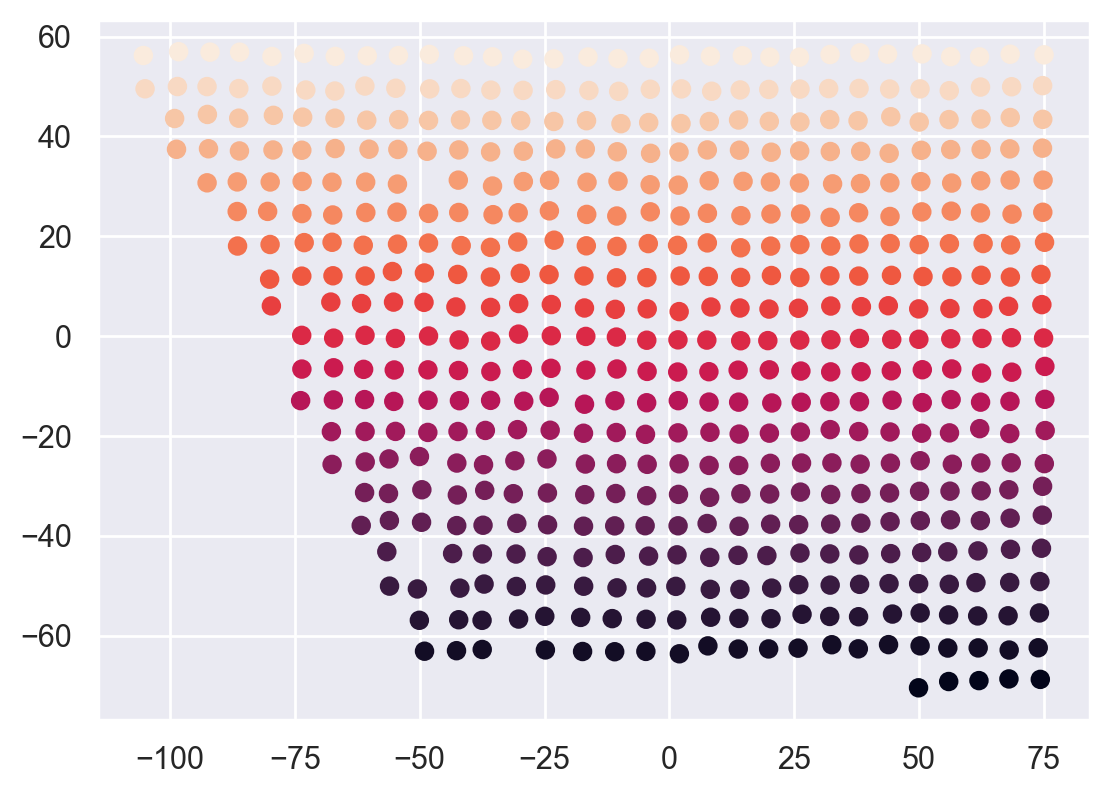

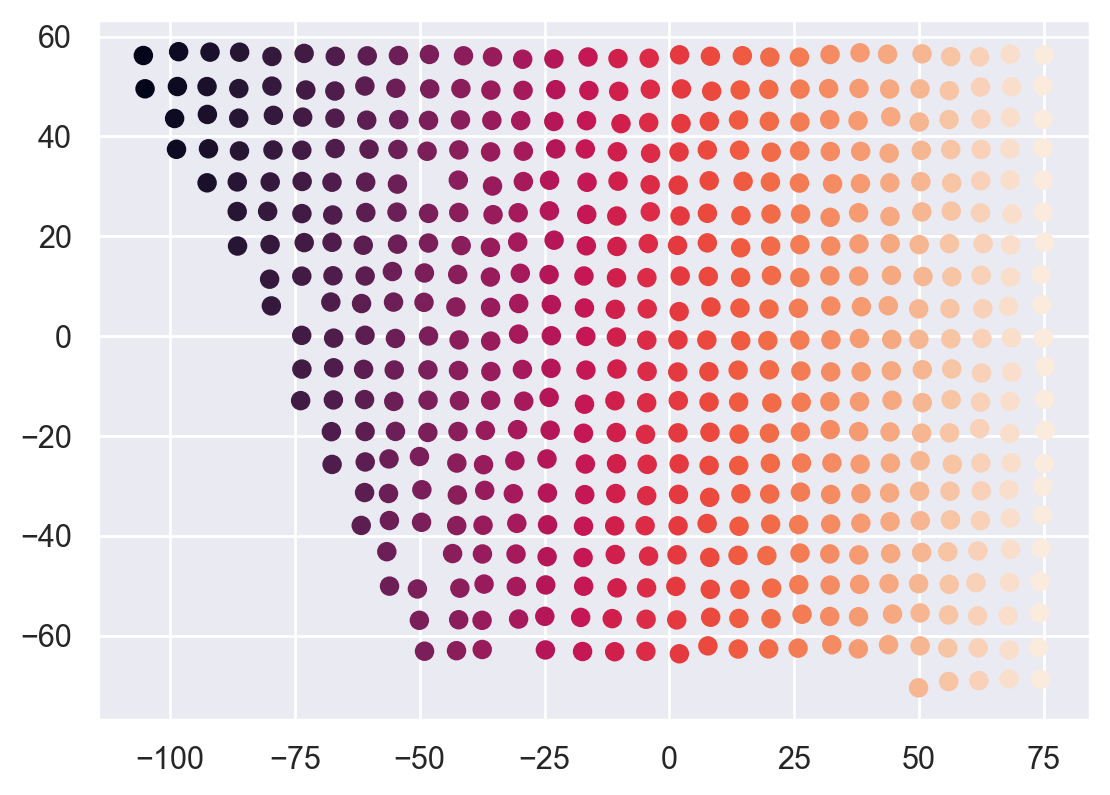

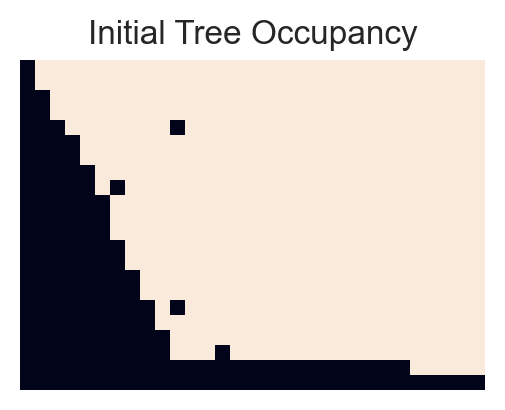

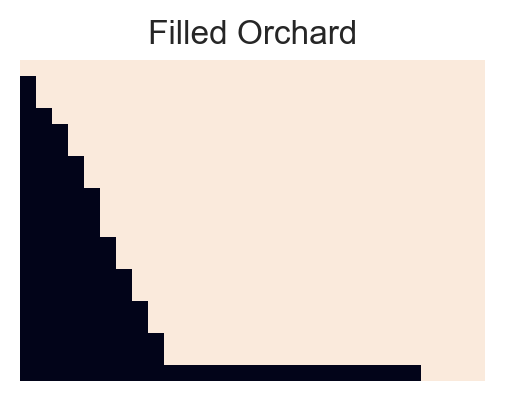

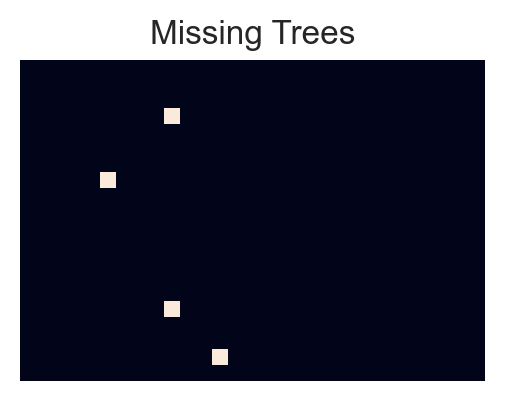

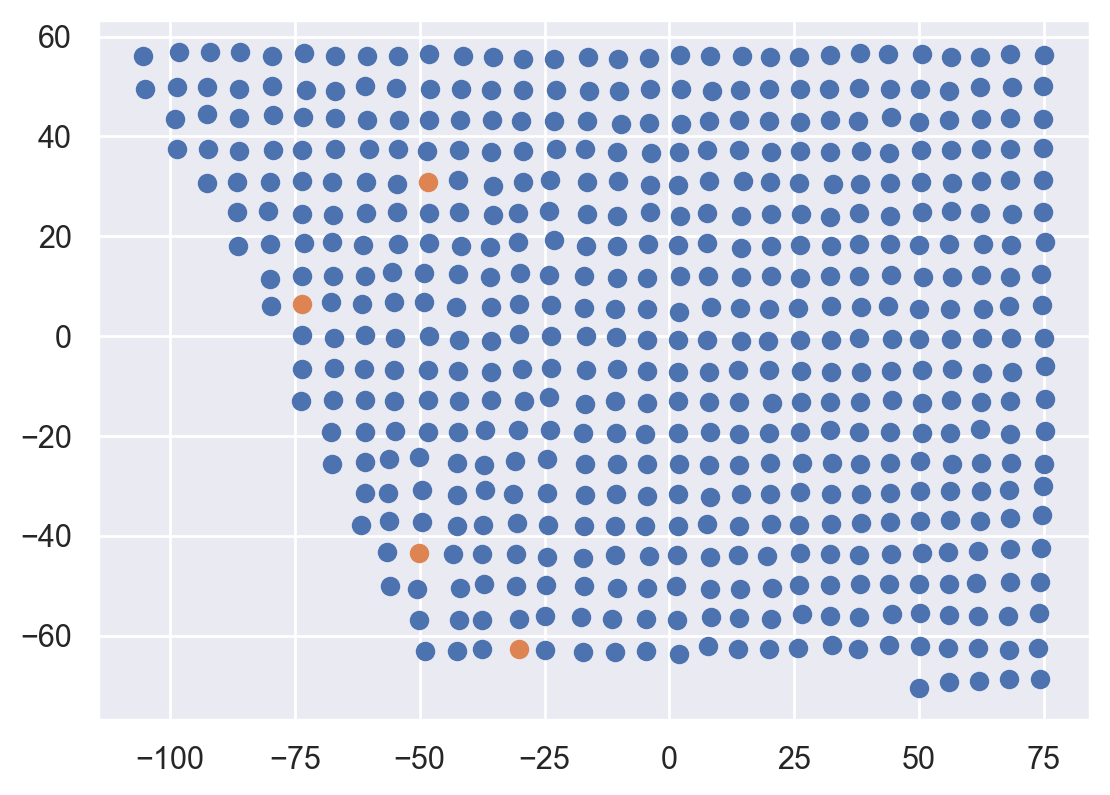

In [72]:
grid = Grid(gdf['latitude'].values, gdf['longitude'].values)
grid.plot(c=grid.rows)
plt.show()

grid.plot(c=grid.cols)
plt.show()

missing = grid.detect_missing_points()
ax = grid.plot()
ax.scatter(x=missing[:,0], y=missing[:,1])
plt.show()


# TODO: Convert back to lat lon

In [68]:
A = np.array([[1, 0, 1],
              [0, 5, 1],
              [3, 0, 0]])

np.array(np.nonzero(A)).T

array([[0, 0],
       [0, 2],
       [1, 1],
       [1, 2],
       [2, 0]])